<a href="https://colab.research.google.com/github/daniilprigozhin/NLRCladeFinder/blob/main/NLRCladeFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program takes an immunoprotein sequence for Soy, Maize, or Arabidopsis and returns the clade in which this protein lies in relation to known subspecies. We also return a Shannon Entropy model for analyzing highly variable portions of the protein, which can be viewed on Chimera. Please use Chrome for this process to ensure results.

If the program errors out, please re-run the program from the first cell.
Authors: Sanjay Rangavajjhala, Daniil Prigozhin

In [1]:
#@title Install Non-Python Dependencies
#@markdown This block may take 4-5 minutes. If it says your session crashed, do not be alarmed and rerun this code block before running the next code block. This is a bug from importing one of the necessary packages onto Colab.

!pip install -q condacolab &> /dev/null
import condacolab
condacolab.install()
!conda install -c bioconda hmmer &> /dev/null
!conda install -c bioconda mafft &> /dev/null
!pip install Bio &> /dev/null
from collections import defaultdict
from Bio import SearchIO
!conda install -c bioconda epa-ng &> /dev/null
!conda install -c bioconda gappa &> /dev/null
from google.colab import files
!pip install toytree &> /dev/null
import toyplot.svg

from Bio import AlignIO

✨🍰✨ Everything looks OK!


In [2]:
#@title Install Python Dependencies
!pip install -q gwpy &> /dev/null
!conda install -c bioconda hmmer &> /dev/null
!conda install -c bioconda mafft &> /dev/null
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import toytree       # a tree plotting library
import toyplot       # a general plotting library

In [3]:
#@title Select Species
Species = "Arabidopsis" #@param ["Soy", "Arabidopsis", "Maize"]

%cd /content
!rm -rf NLRome_Align_Tree
!git clone https://github.com/daniilprigozhin/NLRome_Align_Tree &> /dev/null
 
%cd NLRome_Align_Tree/
if Species == 'Soy':
  %cd Soy_NLRome
  common = pd.read_csv("Soy_NLRome_GeneTable.txt", sep='\t')
elif Species == "Arabidopsis":
  %cd Atha_NLRome
  common = pd.read_csv("Atha_NLRome_GeneTable.txt", sep = '\t')
else:
  %cd Maize_NLRome
  common = pd.read_csv("Maize_NLRome_GeneTable.txt", sep = '\t')


clades = common[["Clade", "File"]].groupby("Clade").first()
!unzip All_Clades.zip

/content
/content/NLRome_Align_Tree
/content/NLRome_Align_Tree/Atha_NLRome
Archive:  All_Clades.zip
  inflating: All_Clades.hmm          


In [4]:
# Code used from https://github.com/sokrypton/ColabFold
import re
import hashlib

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MGSVMSLGCS KRKATNQDVD SESRKRRKIC STNDAENCRF IQDESSWKHP   51 WSLCANRVIS VAAVALTNFR FQQDNQESNS SSLSLPSPAT SVSRNWKHDV  101 FPSFHGADVR RTFLSHIMES FRRKGIDTFI DNNIERSKSI GPELKEAIKG  151 SKIAIVLLSR KYASSSWCLD ELAEIMKCRQ MVGQIVMTIF YEVDPTDIKK  201 QTGEFGKAFT KTCRGKPKEQ VERWRKALED VATIAGYHSH SWRNEADMIE  251 KISTDVSNML NSFTPSRDFD GLVGMRAHMD MLEQLLRLDL DEVRMIGIWG  301 PPGIGKTTIA RFLFNQVSDR FQLSAIMVNI KGCYPRPCFD EYSAQLQLQN  351 QMLSQMINHK DIMISHLGVA QERLRDKKVF LVLDEVDQLG QLDALAKETR  401 WFGPGSRIII TTEDLGVLKA HGINHVYKVE YPSNDEAFQI FCMNAFGQKQ  451 PHEGFDEIAW EVTCLAGELP LGLKVLGSAL RGKSKREWER TLPRLKTSLD  501 GKIGSIIQFS YDVLCDEDKY LFLYIACLFN GESTTKVKEL LGKFLDVKQG  551 LHLLAQKSLI SFDGERIHMH TLLEQFGRET SRKQFVHHGF TKRQLLVGAR  601 GICEVLDDDT TDSRRFIGIH LELSNTEEEL NISEKVLERV HDFHFVRIDA  651 SFQPERLQLA LQDLIYHSPK IRSLNWYGYE SLCLPSTFNP EFLVELDMRS  701 SNLRKLWEGT KQLRNLKWMD LSYSSYLKEL PNLSTATNLE ELKLRNCSSL  751 VELPSSIEKL TSLQILDLEN CSSLEKLPAI ENATKLRELK LQNCSSLIEL  801 PLSIGTATNL KQLNISGCSS LVKLPSSIGD ITDLEVFDLS NCSSLVTLPS  851 SIGNLQNLCK LIMRGCSKLE ALPININLKS LDTLNLTDCS QLKSFPEIST  901 HISELRLKGT AIKEVPLSIM SWSPLADFQI SYFESLMEFP HAFDIITKLH  951 LSKDIQEVPP WVKRMSRLRD LSLNNCNNLV SLPQLSDSLD YIYADNCKSL 1001 ERLDCCFNNP EIRLYFPKCF KLNQEARDLI MHTCIDAMFP GTQVPACFIH 1051 RATSGDSLKI KLKESPLPTT LRFKACIMLV KVNEELMSYD QTPMIVDIVI 1101 RDEHNDLKEK IYPSIYPSIY PLLTEHIYTF ELDVEEVTST ELVFEFPQLN 1151 KRNWKIGECG ILQRETRSLR RSSSPDLSPE SSRVSSYDHC LRGKNHGFDF 1201 SLSHSMDSII GFILCEWELA VKYGFCMDFM SFVFVVYLER' #@param {type:"string"}
# remove whitespaces
query_sequence = "".join(query_sequence.split())
query_sequence = re.sub(r'[^a-zA-Z]','', query_sequence).upper()

jobname = 'RppC' #@param {type:"string"}
# remove whitespaces
jobname = "".join(jobname.split())
jobname = re.sub(r'\W+', '', jobname)
jobname_unhashed = jobname
jobname = add_hash(jobname, query_sequence)

%mkdir {jobname}
%cd {jobname}


with open(f"{jobname}.fasta", "w") as text_file:
    text_file.write(">" + jobname_unhashed + "\n%s" % query_sequence)

/content/NLRome_Align_Tree/Atha_NLRome/RppC_5bf55


In [5]:
#@title Create an Annotated Tree with your protein included
!hmmsearch --domtblout {jobname}.tbl.out ../All_Clades.hmm {jobname}.fasta &> /dev/null

filename = jobname + ".tbl.out"

attribs = ['bias', 'bitscore',  'evalue']

hits = defaultdict(list)
names = []

with open(filename) as handle:
    for queryresult in SearchIO.parse(handle, 'hmmsearch3-domtab'):
      #print(queryresult.id)
      #print(queryresult.accession)
      #print(queryresult.description)
      for hit in queryresult.hsps:
        names.append(queryresult.id)
        for attrib in attribs:
          hits[attrib].append(getattr(hit, attrib))

final = pd.DataFrame.from_dict(hits)
final["Clade"] = names
final.sort_values("bitscore", ascending = False)

#common = pd.read_csv("Soy_NLRome_GeneTable.txt", sep='\t')

final_hv = final.set_index("Clade").join(common[["Clade", "HV", "File"]].groupby("Clade").agg(max), how = 'left', rsuffix = "_other").sort_values("bitscore", ascending = False)
best_afa_file = final_hv.iloc[0,:]["File"]
best_afa = "../" + best_afa_file

!mafft --add {jobname}.fasta --keeplength {best_afa} > {jobname}.updated.afa

clade_oi = common[common["File"] == best_afa_file].iloc[0,:]["Clade"]
tree_oi = best_afa[:best_afa.find("Int")] + "RAxML_bestTree." + clade_oi + ".Raxml.out"
raxml_info_oi = best_afa[:best_afa.find("Int")] + "RAxML_info." + clade_oi + ".Raxml.out"

!epa-ng --split {best_afa} {jobname}.updated.afa --tree {tree_oi} --model {raxml_info_oi}
!cut -f1 -d ' ' {best_afa} > best_afa_f.afa
!epa-ng --ref-msa best_afa_f.afa --tree {tree_oi} -q query.fasta --model {raxml_info_oi} --redo

!gappa examine graft --jplace-path ./ &> /dev/null

tree_created = True

is_hv = final_hv.iloc[0,:]["HV"] == 1

nadd = 1
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
  301 / 320
done.

Constructing a UPGMA tree (efffree=0) ... 
  310 / 320
done.

Progressive alignment 1/2... 
STEP    18 / 319  f
done.

Making a distance matrix from msa.. 
  300 / 320
done.

Constructing a UPGMA tree (efffree=1) ... 
  310 / 320
done.

Progressive alignment 2/2... 
STEP    12 / 319  f
done.

disttbfast (aa) Version 7.508
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add 

In [6]:
#@title View tree
#@markdown Large trees may not display well, consider viewing in an external site.
directory = os.getcwd()
file_name = directory + "/epa_result.newick" 
tre = toytree.tree(file_name)
canvas, axes, mark = tre.draw(tip_labels=True, width = 500, height = 20 * len(tre.get_tip_labels()), scalebar = True)
svg_file_name = directory + "/tree-plot.svg"
toyplot.svg.render(canvas, svg_file_name)
tre.draw(tip_labels=True, width = 500, height = 20 * len(tre.get_tip_labels()), scalebar = True);

<svg class="toyplot-canvas-Canvas" height="6400.0px" id="tfab4e8b674f64b13816646fad211c94e" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 500.0 6400.0" width="500.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 9550_T159-R1 9134_T248-R1 6906_T181-R1 6924_T302-R1 9669_T149-R1 7067_T226-R1 9721_T175-R1 7373_T221-R1 1925_T193-R1 6899_T256-R1 7396_T360-R1 6981_T185-R1 5784_T157-R1 7167_T185-R1 9654_T208-R1 7373_T065-R1 9792_T152-R1 9784_T228-R1 7328_T177-R1 9533_T102-R1 9762_T338-R1 7322_T250-R1 ATHALIANA_AT3G44400_1 6909_T120-R1 7186_T100-R1 9518_T260-R1 9869_T320-R1 7167_T215-R1 9669_T288-R1 9610_T421-R1 9869_T213-R1 9871_T269-R1 6899_T265-R1 9518_T006-R1 9549_T237-R1 9518_T047-R1 9100_T114-R1 7417_T209-R1 9721_T333-R1 9550_T403-R1 9537_T106-R1 9654_T117-R1 9610_T091-R1 9549_T322-R1 7396_T296-R1 9947_T311-R1 9887_T135-R1 7308_T072-R1 108_T295-R1 9543_T462-R1 5784_T292-R1 7396_T269-R1 5784_T293-R1 6974_T351-R1 9597_T240-R1 7322_T452-R1 9536_T225-R1 6939_T421-R1 7322_T430-R1 7067_T085_1-R1 6939_T142-R1 5993_T391-R1 9600_T074-R1 5993_T063-R1 5993_T062-R1 7417_T076-R1 108_T210-R1 6974_T460-R1 6939_T293-R1 7413_T243-R1 10015_T237-R1 9871_T359-R1 9536_T244-R1 9550_T435-R1 7328_T325-R1 9879_T344-R1 6924_T245-R1 1925_T430-R1 7416_T371-R1 7308_T011_1-R1 7415_T313-R1 9134_T276-R1 7417_T202-R1 9837_T319-R1 9537_T056-R1 9654_T311-R1 9871_T429-R1 6974_T382-R1 9533_T449-R1 9871_T080-R1 9332_T328-R1 9533_T100-R1 7213_T125-R1 9580_T303-R1 9600_T311-R1 9944_T250-R1 7186_T058-R1 6899_T180-R1 9762_T418-R1 9542_T063_2-R1 9669_T090-R1 9721_T355-R1 9332_T130-R1 9518_T512-R1 9518_T328-R1 6909_T282-R1 ATHALIANA_AT3G44670_1 9332_T307-R1 9550_T343-R1 9536_T210-R1 9669_T550-R1 9669_T580-R1 7167_T221-R1 5993_T066-R1 9550_T219-R1 6974_T375-R1 9610_T495-R1 9887_T301-R1 9947_T349-R1 9580_T550-R1 9580_T054-R1 9537_T053-R1 9549_T228-R1 10015_T209-R1 6939_T661-R1 7322_T327-R1 ATHALIANA_AT3G44480_1 RppC 6909_T229-R1 9762_T394-R1 7111_T346-R1 7415_T237-R1 9533_T332-R1 9550_T413-R1 7186_T207-R1 9792_T280-R1 9784_T313-R1 6924_T310-R1 9944_T074-R1 7167_T190-R1 7186_T056-R1 9518_T002-R1 6939_T553-R1 9554_T286-R1 9554_T266-R1 6906_T133-R1 6899_T421-R1 9669_T351-R1 9669_T087-R1 10015_T208-R1 9100_T335-R1 9792_T134-R1 7373_T145-R1 6981_T275-R1 6899_T096-R1 5784_T119-R1 9764_T326-R1 7416_T083-R1 1925_T200-R1 7396_T299-R1 6939_T175-R1 7322_T158-R1 6906_T131-R1 9100_T111-R1 9944_T072-R1 9543_T298-R1 9837_T209-R1 9597_T483-R1 7308_T069-R1 7288_T207-R1 5784_T043-R1 5784_T328-R1 9100_T329-R1 7373_T231-R1 10015_T218-R1 9792_T130-R1 9784_T315-R1 1925_T087-R1 7416_T187-R1 108_T297-R1 10015_T098-R1 9871_T397-R1 6939_T602-R1 7413_T402-R1 7413_T403-R1 10015_T254-R1 6974_T329-R1 6906_T340-R1 9837_T465-R1 6906_T290-R1 9669_T317-R1 9721_T382-R1 9134_T292-R1 5993_T247-R1 9764_T276-R1 7396_T335-R1 7328_T258-R1 7413_T212-R1 6981_T283-R1 9600_T386-R1 6906_T370-R1 9533_T143-R1 7328_T358-R1 9543_T392-R1 9600_T102-R1 9869_T322-R1 9669_T532-R1 9721_T376-R1 9610_T089-R1 9654_T119-R1 7213_T204-R1 6909_T531-R1 6974_T323-R1 9543_T259-R1 7413_T289-R1 ATHALIANA_AT3G44630_1 6909_T338-R1 9536_T306-R1 7273_T128-R1 108_T187-R1 7213_T092-R1 7308_T011_2-R1 7415_T206-R1 6939_T179-R1 7322_T156-R1 6899_T181-R1 9549_T213-R1 9762_T325-R1 9542_T250-R1 7111_T227-R1 9600_T491-R1 7058_T270-R1 9134_T328-R1 9654_T466-R1 9669_T258-R1 9583_T277-R1 9550_T390-R1 9597_T433-R1 7373_T249-R1 9784_T181-R1 9100_T396-R1 9871_T488-R1 7058_T400-R1 9879_T429-R1 7167_T281-R1 7413_T187-R1 9654_T222-R1 108_T189-R1 7417_T079-R1 7373_T157-R1 6899_T382-R1 7111_T324-R1 9536_T190-R1 9332_T509-R1 6906_T325-R1 9762_T354-R1 9332_T279-R1 9533_T358-R1 108_T212-R1 10015_T097-R1 9543_T185-R1 9100_T138-R1 9518_T19

In [7]:
#@title This block will tell you if your sequence falls within a highly variable clade.
if is_hv:
  print("Your protein belongs to a highly variable clade.")
else:
  print("Your protein is not in a highly variable clade.")


Your protein belongs to a highly variable clade.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


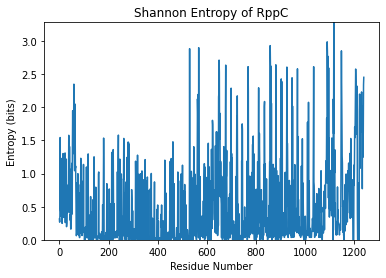

In [23]:
#@title Above ends the process of tree creation. Here we create a Shannon Entropy model (receommended for proteins in highly variable clades), and print the graphed entropy results.
def entropy(string):
    "Calculates the Shannon entropy of a string"
    string = string.replace("-","")
    # get probability of chars in string
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list("ARNDCQEGHILKMFPSTWYV")) ]

    # calculate the entropy
    entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob if p > 0])

    return entropy

gene = query_sequence
cn = jobname_unhashed
file_oi = jobname + ".updated.afa"

align = AlignIO.read(file_oi, "fasta")

length = len(align[1,:])
entropies = []
for i in range(length):
  col = align[:,i]
  if col[len(align) - 1] == "-":
    continue
  entropies.append(entropy(col))

f = open(jobname+"_Chimera_Entropy.txt", "w")
f.write("attribute: shannonEntropy\n")
f.write("match mode: 1-to-1\n")
f.write("recipient: residues\n")
for i in range(1,len(entropies)+1):
  f.write("\t:")
  f.write(str(i))
  f.write("\t")
  f.write(str(entropies[i-1]))
  f.write("\n")
f.close()

ylim = max(max(entropies), 2.5)

plt.ylim(0,ylim);
plt.plot(entropies);
plt.xlabel("Residue Number");
plt.ylabel("Entropy (bits)");
plt.title("Shannon Entropy of "+jobname_unhashed);
plt.savefig(jobname + "_Entropy_MaskedNG");
plt.savefig(jobname + "_Entropy_MaskedNG.svg")

shannon_created = True

residue_entropies = pd.DataFrame()
residues = []
unfiltered_entropies = []

for i in range(length):
  residues.append(align[len(align) - 1,i])
  col = align[:,i]
  if col[len(align) - 1] == "-":
    continue
  else:
    unfiltered_entropies.append(entropy(col))

residue_entropies["residue"] = residues
residue_entropies = residue_entropies[residue_entropies["residue"] != "-"]
residue_entropies["entropy"] = unfiltered_entropies
residue_entropies = residue_entropies.reset_index(drop = True)
residue_entropies["position"] = residue_entropies.index + 1
cols = residue_entropies.columns.tolist()
cols = cols[-1:] + cols[:-1]
residue_entropies = residue_entropies[cols].round(3)
residue_entropies.to_csv('residue_entropies.txt', index=None, sep='\t')

!mkdir filtered_residues

In [24]:
#@title Enter the Lower Bound for Entropy Values of Interest (suggested 0.8-1.8)
#@markdown Feel free to run this multiple times with different entropy_lb values.

entropy_lb = 0.8 #@param {type:"number"}


# bins = np.arange(-0.25,0.25 + round(max(unfiltered_entropies) * 2) / 2,0.25)
#residue_entropies["binned"] = pd.cut(residue_entropies["entropies"], bins)
sorted_filtered_re = residue_entropies[residue_entropies["entropy"] >= entropy_lb].sort_values("entropy", ascending = False).reset_index(drop = True)
sorted_filtered_re["rank"] = sorted_filtered_re.index + 1

sorted_fre_name = 'filtered_residues/filtered_residue_entropies_' + str(entropy_lb) + '.txt'
sorted_filtered_re.to_csv(sorted_fre_name, index=None, sep='\t')
sorted_filtered_re.head(80)


,position,residue,entropy,rank
0,1118,S,3.285,1
1,1091,Q,2.990,2
2,859,C,2.934,3
3,568,H,2.902,4
4,531,G,2.887,5
...,...,...,...,...
75,625,N,1.744,76
76,1013,R,1.733,77
77,65,A,1.722,78
78,61,V,1.718,79


In [ ]:
#@title Download Results
#@markdown Our assembled zip file contains the tree created in Newick format and an updated aligned fasta format of your sequence against all other proteins in your species. \
#@markdown \
#@markdown If a Shannon Entropy model was generated, it also includes the Chimera-formatted entropy mapping, as well as the graph generated above of entropy per residue. The entropy-filtered residue tables are also included. \
#@markdown \
#@markdown If you are having issues downloading the result, try disabling your adblocker and run this cell again. If that fails click on the folder icon to the left, navigate to /content, and manually download {jobname}_results.zip.

new_folder = jobname_unhashed + "_results"
!mkdir {new_folder}
!mv {jobname}.updated.afa {new_folder}
!mv epa_result.newick {new_folder}
!mv tree-plot.svg {new_folder}
if shannon_created:
  %mv {jobname}_Chimera_Entropy.txt {new_folder}
  %mv {jobname}_Entropy_MaskedNG.png {new_folder}
  %mv {jobname}_Entropy_MaskedNG.svg {new_folder}
  %mv residue_entropies.txt {new_folder}
  %mv -v filtered_residues/* {new_folder}

!mv {new_folder} ../../
%cd /content/NLRome_Align_Tree/
!zip -r {new_folder}.zip {new_folder}
res = new_folder + ".zip"
files.download(res)

**References:**

A. Stamatakis: "RAxML Version 8: A tool for Phylogenetic Analysis and Post-Analysis of Large Phylogenies". In Bioinformatics, 2014, open access.

Eaton DAR. Toytree: A minimalist tree visualization and manipulation library for Python. Methods Ecol Evol. 2020;11:187–191. https://doi.org/10.1111/2041-210X.13313

Haun WJ, Hyten DL, Xu WW, Gerhardt DJ, Albert TJ, Richmond T, Jeddeloh JA, Jia G, Springer NM, Vance CP, Stupar RM. The composition and origins of genomic variation among individuals of the soybean reference cultivar Williams 82. Plant Physiol. 2011 Feb;155(2):645-55. doi: 10.1104/pp.110.166736. Epub 2010 Nov 29. PMID: 21115807; PMCID: PMC3032456.

Jumper, J et al. Highly accurate protein structure prediction with AlphaFold. Nature (2021).

Katoh K, Standley DM. MAFFT multiple sequence alignment software version 7: improvements in performance and usability. Mol Biol Evol. 2013 Apr;30(4):772-80. doi: 10.1093/molbev/mst010. Epub 2013 Jan 16. PMID: 23329690; PMCID: PMC3603318.

Varadi, M et al. AlphaFold Protein Structure Database: massively expanding the structural coverage of protein-sequence space with high-accuracy models. Nucleic Acids Research (2021).



